# Previsão de necessidade de tratamento em UTI através de modelos de machine learning

Thamirys de Oliveira

thamirysolv01@gmail.com

# Introdução

A COVID-19, doença causada pelo vírus SARS-COV-2, afeta todo o planeta desde o ano de 2019. Altas taxas de transmissão do vírus podem causar o colapso do sistema de saúde através, entre outro modos, da falta de leitos de UTI disponíveis para a população, o que pode gerar filas [[1]](https://g1.globo.com/bemestar/coronavirus/noticia/2021/03/20/mortes-na-fila-por-um-leito-de-uti-falta-de-insumos-e-funerarias-sem-ferias-os-sinais-do-colapso-na-saude-brasileira.ghtml). Prever se um paciente que der entrada no hospital precisará de atendimento em UTI ou não pode ser uma das formas de diminuir as chances de fila para leitos, pois assim, por exemplo, o hospital tem mais tempo para abrir novos leitos ou agendar a transferência do paciente para outro hospital com leitos disponíveis.

Usando uma [base de dados](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) de internações por COVID-19 disponibilizada pelo hospital Sírio-Libanês e modelos de machine learning através da biblioteca scikit-learn [[2]](https://scikit-learn.org/stable/), neste projeto vamos gerar um modelo que possa prever se um paciente precisará de atendimento em UTI ou não. 

O projeto está dividido da seguinte maneira: 
- Primeiramente analisaremos a base de dados sem o uso de machine learning para tentar detectar algum padrão entre os pacientes que presisaram de atendimento de UTI;
- Posteriormente, usando algoritmos de machine learning, selecionaremos o modelo com melhor performance através de dois métodos distintos para prever se um paciente precisará ou não de atendimento em UTI.

# Análise

### Pacotes e funções

Nesta seção estão os pacotes necessários para a realização da análise, bem como as funções criadas durante a análise.

In [1]:
import pandas as pd
import seaborn as sns
#sns.set(font_scale = 2)
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
#mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

from scipy.stats import randint

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV

In [3]:
def raw_data():
    '''CARREGANDO BASE DE DADOS'''
    raw_data = pd.read_excel('./Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')
    raw_data.loc[raw_data['AGE_PERCENTIL'] != 'Above 90th', 'AGE_PERCENTIL'] = raw_data.AGE_PERCENTIL.str.slice(0,2)
    raw_data.loc[raw_data['AGE_PERCENTIL'] == 'Above 90th', 'AGE_PERCENTIL'] = '100'
    raw_data.AGE_PERCENTIL = raw_data.AGE_PERCENTIL.astype(int)
    
    def fill_nan(dados):
        features_continuas_colunas = dados.iloc[:, 13:-2].columns
        features_continuas = dados.groupby(by=['PATIENT_VISIT_IDENTIFIER'], as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')

        features_categoricas = dados.iloc[:, :13]
        saida = dados.iloc[:, -2:]
        dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
        dados_finais.columns = dados.columns
        return dados_finais

    raw_data = fill_nan(raw_data)
    return raw_data

def raw_data_grouped_id():
    '''AGRUPANDO DADOS POR ID DO PACIENTE'''
    return raw_data().groupby(by=['PATIENT_VISIT_IDENTIFIER'], as_index=False).max()

def plot_internacoes():
    '''PLOT INTERNAÇÕES POR IDADE, SEXO, E ICU'''
    colormap=plt.get_cmap('tab10')
    ax=sns.displot(x='AGE_PERCENTIL', hue='ICU', col='GENDER', 
        data=raw_data_grouped_id(), multiple='stack', palette = [colormap(0), colormap(1)], legend=False)
    ax.set_axis_labels('Intervalo de idade', '#')
    plt.legend(title = 'UTI', labels=['1', '0'])
    ax.set_titles(size=12,col_template='Sexo = {col_name}')
    ax.fig.subplots_adjust(top=0.85)
    ax.fig.suptitle('Número de internações por intervalo de idade, sexo, e UTI', fontsize=14)
    ax.set(xticks=range(14, 100, 18), xticklabels=list(("10","30","50","70","90")))

def filtered_raw_data():
    '''FILTRANDO DADOS PARA ANÁLISE COM MACHINE LEARNING'''
    filter = raw_data().query("WINDOW=='0-2' and ICU==1").PATIENT_VISIT_IDENTIFIER.values
    filtered_raw_data = raw_data().query('PATIENT_VISIT_IDENTIFIER not in @filter')
    def prepare_window(rows):
        if(np.any(rows['ICU'])):
            rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
        return rows.loc[rows['WINDOW']=='0-2']
    filtered_raw_data = filtered_raw_data.groupby(by=['PATIENT_VISIT_IDENTIFIER'], as_index=False).apply(prepare_window)
    filtered_raw_data = filtered_raw_data.dropna()
    return filtered_raw_data

def raw_model(model):
    '''RODANDO MODELO COM PARÂMETROS DEFAULT E PLOTANDO MATRIZ DE CONFUSÃO'''
    np.random.seed(5678)
    model = model()
    model.fit(x_train, y_train)
    y_prediction=model.predict(x_test)
    print(f'Taxa de acerto: {"%.1f" %(accuracy_score(y_test, y_prediction)*100)}%')

    plot_confusion_matrix(model, x_test, y_test)

def confusion_matrix_false_negative(icu_right_prediction, icu_wrong_prediction):
    '''CALCULANDO A TAXA DE FALSO NEGATIVO PARA O MODELO'''
    print(f'Taxa de falso negativo: {"%.1f" %((icu_wrong_prediction/(icu_right_prediction+icu_wrong_prediction))*100)}%')


def cross_validate_raw_model(model, n_splits=5, n_repeats=10):
    '''RODANDO MODELO COM PARÂMETROS DEFAULT E CROSS VALIDATE'''   
    np.random.seed(5678)
    
    # embaralhando os dados:
    dados_xy = filtered_raw_data().sample(frac=1).reset_index(drop=True)

    y = dados_xy['ICU']
    x = dados_xy[dados_xy.columns].drop(['ICU', 'WINDOW'], axis = 'columns')

    model = model()
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    resultados = cross_validate(model, x, y, cv=cv, scoring='accuracy')['test_score']

    acuracia_media = resultados.mean()
    acuracia_std = resultados.std()
    print(f'Acurácia média {"%.1f" %(acuracia_media*100)}%')
    print(f'Intervalo de acurácia: {"%.1f" %((acuracia_media - 2*acuracia_std)*100)}% - {"%.1f" %((acuracia_media + 2*acuracia_std)*100)}%')

def corr_selected_filtered_raw_data():
    '''SELECIONANDO FEATURES ATRAVÉS DA CORRELAÇÃO'''
    matrix_corr = filtered_raw_data().iloc[:,4:-2].corr()
    upper_matrix = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    excluir = [coluna for coluna in upper_matrix.columns if any(upper_matrix[coluna] > 0.90)]
    dados = filtered_raw_data().drop(excluir, axis='columns')
    return dados

def RFECV_selected_filtered_raw_data():
    '''SELECIONANDO FEATURES ATRAVÉS DO RFECV'''
    np.random.seed(5678)
    model = RandomForestClassifier()
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    selected_RFECV = RFECV(estimator=model, cv=cv, scoring='accuracy')
    selected_RFECV.fit(x, y)
    return selected_RFECV

def plot_features(result):
    '''PLOT SELEÇÃO DE FEATURES'''
    colormap=plt.get_cmap('tab10')
    plt.plot(range(1, len(result.cv_results_['mean_test_score']) + 1), result.cv_results_['mean_test_score'], color=colormap(0))
    plt.plot(result.n_features_,result.cv_results_['mean_test_score'].max(), color=colormap(3), marker='o')
    plt.vlines(x=result.n_features_, ymin=0.55, ymax=result.cv_results_['mean_test_score'].max(), color=colormap(3), linestyle='--', alpha=0.5)
    plt.hlines(y=result.cv_results_['mean_test_score'].max(), xmin=0, xmax=result.n_features_, color=colormap(3), linestyle='--', alpha=0.5)
    plt.grid()
    plt.xlabel('# de features')
    plt.ylabel('Acurácia')
    plt.title('Acurácia pelo número de features selecionadas com RFECV', loc='left')
    plt.xticks(range(0, len(result.cv_results_['mean_test_score']) + 1, 10))
    plt.xlim(0,len(result.cv_results_['mean_test_score'])+1)
    plt.ylim(0.55,0.80)


### Base de dados

A base de dados utilizada para esta análise pode ser encontrada em [kaggle: COVID-19 - Clinical data to assess diagnosis](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19) e trata-se de dados obtidos do hospital Sírio-Libanês em São Paulo e em Brasília. Os dados foram disponibilizados limpos e normalizados.

Visualizando as primeiras cinco linhas do dataframe temos:

In [4]:
raw_data().head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,6-12,0
4,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


A função raw_data() carrega a base de dados, preenche os 'NaN' nas colunas com os resultados de exames com os valores previamente obtidos para cada paciente e transforma a coluna 'AGE_PERCENTIL' de string para int (idades 'Above 90th' foram transformadas em '100').

Portanto, temos disponível neste dataframe um 'id' para cada paciente, se a idade do paciente é maior que 65 anos (1) ou não (0), a faixa de idade deste paciente (em intervalos de 10 anos), gênero, doenças previamente existentes, resultado dos exames feitos depois que o paciente deu entrada no hospital, a janela de horas depois da entrada no hospital para o resultado de cada exame (em intervalos de 2 horas), e se o paciente precisou dar entrada na UIT (1) ou não (0).

Agrupando os dados por id do paciente:

In [5]:
raw_data_grouped_id()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1
1,1,1,90,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.142857,-0.797980,0.315690,0.200359,-0.239515,0.645161,0.139709,-0.802317,ABOVE_12,1
2,2,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.797980,-0.515528,-0.343258,-0.576744,-0.695341,-0.505464,-0.801293,ABOVE_12,1
3,3,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.047619,-0.171717,-0.308696,-0.057718,-0.069094,-0.329749,-0.047619,-0.172436,ABOVE_12,0
4,4,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.642857,-0.939394,-0.652174,-0.596165,-0.634847,-0.817204,-0.645793,-0.940077,ABOVE_12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,380,0,40,1,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.523810,-0.717172,-0.505721,-0.119847,-0.553531,-0.245968,-0.535361,-0.717417,ABOVE_12,1
381,381,1,100,0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-0.959596,-0.982609,-0.871507,-0.804670,-0.878136,-0.612627,-0.960052,ABOVE_12,0
382,382,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.500000,-0.838384,-0.513996,-0.236377,-0.617378,-0.191851,-0.498615,-0.835052,ABOVE_12,1
383,383,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.571429,-0.838384,-0.552795,-0.585967,-0.557252,-0.573477,-0.572609,-0.838524,ABOVE_12,0


Ou seja, temos um total de 385 pacientes.

Agrupando pela coluna ICU e contando o número de pacientes:

In [6]:
raw_data_grouped_id().groupby(by=['ICU'], as_index=False).count().rename(columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'}).TOTAL

0    190
1    195
Name: TOTAL, dtype: int64

No total temos 190 pacientes que não precisaram de atendimento em UTI e outros 195 pacientes que precisaram.

Agrupando por sexo

In [7]:
raw_data_grouped_id().groupby(by=['GENDER'], as_index=False).count().rename(columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'}).TOTAL

0    243
1    142
Name: TOTAL, dtype: int64

Temos 243 pacientes do sexo masculino e 142 pacientes do sexo feminino, ou seja, o número de pacientes do sexo masculino representa 63% do total. A legenda para a coluna 'GENDER' (0=masculino, e 1=feminino) foi discutida em [[3]](https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/164019) no kaggle.

In [8]:
raw_data_grouped_id().groupby(by=['GENDER', 'ICU'], as_index=False).count()[['GENDER', 'ICU', 
    'PATIENT_VISIT_IDENTIFIER']].rename(columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'})

,GENDER,ICU,TOTAL
0,0,0,108
1,0,1,135
2,1,0,82
3,1,1,60


Dos 243 pacientes masculinos, 108 não precisaram de atendimento na UTI, enquanto que 135 precisaram, ou seja, 55.5% dos pacientes masculinos foram para a UTI. Enquanto que para os pacientes femininos 82 não precisaram de atendimento de UTI e 60 precisaram, ou seja, 42.2% dos pacientes femininos precisaram de atendimento na UTI.

Analisando por idade maior que 65 anos

In [9]:
raw_data_grouped_id().groupby(by=['AGE_ABOVE65'], as_index=False).count().rename(columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'}).TOTAL

0    205
1    180
Name: TOTAL, dtype: int64

Temos que 180 pacientes tem mais de 65 anos de idade, o que representa 46.7% do total de pacientes.

In [10]:
raw_data_grouped_id().groupby(by=['ICU','AGE_ABOVE65'], as_index=False).count()[['ICU', 
    'AGE_ABOVE65','PATIENT_VISIT_IDENTIFIER']].rename(columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'})

,ICU,AGE_ABOVE65,TOTAL
0,0,0,129
1,0,1,61
2,1,0,76
3,1,1,119


E dos 180 pacientes com mais de 65 anos 119 precisaram de atencimendo de UTI. Ou seja, 66% dos pacientes com mais de 65 anos precisaram de atendimento de UTI, além disso, considerando as internações em UTI para todas as idades (195 no total), pessoas com mais de 65 anos representam 61% do total.

Separando os dados de internação por faixa etária, sexo e se o paciente precisou de atendimento em UTI ou não, temos:

In [11]:
raw_data_grouped_id().groupby(by=['ICU','AGE_PERCENTIL', 'GENDER'], as_index=False).count().rename(
    columns={'PATIENT_VISIT_IDENTIFIER': 'TOTAL'})[['AGE_PERCENTIL','GENDER','ICU','TOTAL']].sort_values(by=['AGE_PERCENTIL', 'GENDER'])

,AGE_PERCENTIL,GENDER,ICU,TOTAL
0,10,0,0,22
20,10,0,1,8
1,10,1,0,9
21,10,1,1,2
2,20,0,0,16
22,20,0,1,9
3,20,1,0,15
23,20,1,1,3
4,30,0,0,14
24,30,0,1,14


Para analisar mais facilmente esses dados vamos gerar uma visualização:

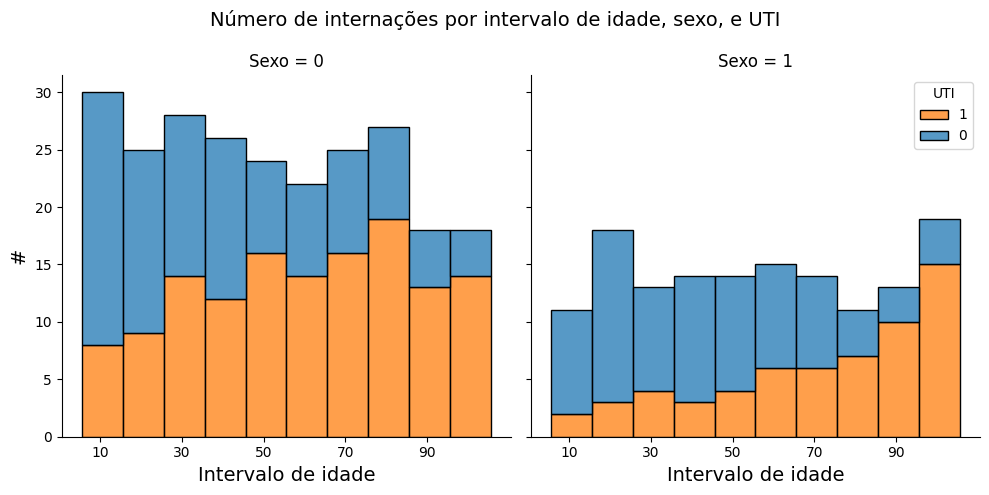

In [12]:
plot_internacoes()

O primeiro resultado que chama atenção neste gráfico é que o número de internações de homens (Sexo = 0) é maior do que de mulheres (Sexo = 1), entretanto este resultado não significa que a COVID-19 é mais grave em homens do que em mulheres pois os dados representam apenas um período limitado no tempo (e não a média dos dados de toda a pandemia), e questões socioeconomicas também devem ser levadas em consideração, pois os dados são de um hospital particular (será que os homens tem mais acesso ao serviço privado de saúde do que as mulheres?).

A segunda análise que podemos fazer deste gráfico é que quanto maior a idade do paciente maior é a chance do mesmo necessitar de um atendimento de UTI, independentemente do sexo.

Entretanto, os dados disponibilizados pelo hospital possuem muito mais informações do que apenas sexo e intervalo de idade do paciente, como, por exemplo, as doenças pré-existentes para cada paciente e o resultado dos exames feitos durante as internações; como pode-se ler em [[4]](https://www.bbc.com/portuguese/geral-52901162), doenças pré-existentes, principalmente as não tratadas, aumentam a chance de um paciente evoluir para um caso mais grave de COVID-19.

In [13]:
raw_data().shape[1]

231

A base de dados possui 231 colunas disponíveis com informações para os 385 pacientes. Dados desta dimensão são inviáveis de serem analisados com um gráfico para cada coluna, como fizemos para o intervalo de idade de cada paciente, e assim calcular manualmente quem tem maior chance de precisar de atendimento em UTI. Para prevermos com uma melhor precisão se um paciente precisará de atendimento em UTI ou não vamos aplicar alguns modelos de machine learning através da biblioteca Scikit-learn.

### Machine Learning

Nosso objetivo é determinar se um paciente precisará de atendimento de UTI ou não, ou seja, queremos identificar se o paciente pertence à categoria UTI = 1 ou UTI = 0. Portanto temos um problema de classificação. Nesta seção vamos comparar os algoritmos de classificação Logistic regression, SVC, Linear SVC, Decision Tree, Random Forest, Gaussian Process, e K-nearest neighbors, e selecionar o que apresentar o melhor desempenho através de dois métodos distintos de análise; além disso, selecionaremos as features mais importantes através da análise da matriz de correlação e do RFECV, e selecionaremos os melhores valores para os parâmetros através da RandomizedSearchCV.

#### Dados treino e teste

Como nosso objetivo é determinar a necessidade ou não de UTI para um paciente, o melhor é que nosso modelo preveja esta necessidade o quanto antes, ou seja, nas primeiras duas horas de internação. Para isso vamos primeiramente eliminar os pacientes que deram entrada no hospital diretamente na UTI, ou seja, na primeira 'WINDOW', pois o resultado dos exames não nos ajudam a prever se o paciente precisará de internação ou não (os exames podem ter sido realizados apenas depois da internação na UTI), posteriormente vamos selecionar os dados das primeiras duas horas de internação dos pacientes restantes (para que a previsão ocorra a partir dos dados das primeiras horas de internação) e, para os pacientes que precisaram de UTI depois da 'WINDOW' de 0-2 horas, vamos alterar o valor da feature 'ICU' para 1 para a 'WINDOW' 0-2, resultando em:

In [14]:
filtered_raw_data()

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,1,60,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,10,2,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,15,3,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,20,4,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,25,5,0,10,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,1900,380,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
349,1905,381,1,100,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
350,1910,382,0,50,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
351,1915,383,0,40,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0


Ou seja, dos 385 pacientes iniciais temos agora 352.

Separando os dados em features $(x)$ e classes $(y)$, onde classes é a coluna 'ICU', que nos diz se o paciente foi para a UTI ou não, e features são todas as outras colunas da base de dados, ou seja, são as colunas que usaremos como input em nosso modelo com o objetivo de prever a coluna 'ICU', temos:

In [15]:
y = filtered_raw_data()['ICU']
x = filtered_raw_data()[filtered_raw_data().columns].drop(['ICU', 'WINDOW'], axis = 'columns')

Em seguida separamos os dados em dados de treino e dados de teste, com testes representando 30% dos dados e mantendo a proporção de casos da variável y:

In [16]:
np.random.seed(5678)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, stratify=y)

In [17]:
print(len(y_train),len(y_test))

246 106


Ou seja, temos 246 dados (70%) no treino e 106 dados (30%) no teste.

In [18]:
print(f'Proporção em y:\n{y.value_counts(normalize=True)}, \n\nProporção em y_train:\n{y_train.value_counts(normalize=True)}, \n\nProporção em y_test:\n{y_test.value_counts(normalize=True)}')

Proporção em y:
0    0.536932
1    0.463068
Name: ICU, dtype: float64, 

Proporção em y_train:
0    0.536585
1    0.463415
Name: ICU, dtype: float64, 

Proporção em y_test:
0    0.537736
1    0.462264
Name: ICU, dtype: float64


Além disso, a proporção entre pacientes que foram para a UTI ou não tanto no treino quanto no teste é aproximadamente a mesma da variável y.

#### Baseline

Para poder dizer se a acurácia do modelo utilizado está 'boa' ou não, vamos começar determinando uma linha de base para a acurácia através de um Dummy Classifier, onde o modelo sempre vai chutar o valor mais frequente em y como predição para os dados de teste, ignorando as features (x). Qualquer outro modelo que formos considerar deverá ter uma acurácia melhor do que o Dummy Classifier.

In [19]:
np.random.seed(5678)
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(x_train, y_train)
dummy_y_prediction=dummy_model.predict(x_test)
print(f'Taxa de acerto: {"%.1f" %(accuracy_score(y_test, dummy_y_prediction)*100)}%')

Taxa de acerto: 53.8%


Sem nenhuma surpresa, como dividimos os dados de treino e teste com a mesma propoção de zeros e uns entre eles, retornar sempre o valor mais frequente resulta em uma taxa de acerto igual à proporção do valor mais frequente, ou seja, resulta em uma taxa de acerto igual à proporção de zeros (53.8%).

#### Selecionando o modelo

Nesta seção vamos analisar diversos modelos presentes no sklearn e selecionar o(s) que apresentar(em) o(s) melhor(es) resultado(s). 

O primeiro método de seleção será feito da seguinte maneira:
- Os dados serão divididos usando train_test_split()
- Os parâmetros dos modelos não serão alterados, ou seja, usaremos os parâmetros 'default' para cada modelo. A escolha dos parâmetros será feita posteriormente apenas para o modelo que apresentar o melhor resultado nesta comparação inicial.
- Todas as features serão consideradas nos dados x_train e x_test, apenas posteriormente selecionaremos as melhores features.
- O modelo deve apresentar uma taxa de acerto maior que 53.8%, a taxa de baseline.
- A matriz de confusão também será utilizada para comparar os modelos. Será considerado que um predição de não necessidade de atendimento de UTI enquanto que o paciente necessitou de atendimento, ou seja, um falso negativo, terá um peso mais negativo no momento da seleção do modelo do que um falso positivo, ou seja, o modelo previu a necessidade de atendimento de UTI enquanto que na realidade o paciente não precisou deste atendimento.

O segundo método de seleção será feito da seguinte maneira:
- Os dados serão divididos usando cross_validate() e RepeatedStratifiedKFold()
- Os parâmetros dos modelos, como no primeiro método, não serão alterados.
- Todas as features serão utilizadas.
- A taxa de acerto será a média da taxas calculadas para cada vez que o algoritmo for rodado (será utilizado n_split=5 com n_repeats=10).
- O modelo deve apresentar uma taxa de acerto maior que 53.8%.

Ao final, o modelo com o melhor resultado no primeiro método e o modelo com o melhor resultado no segundo método serão selecionados. Se o mesmo modelo obtiver o melhor resultado nos dois métodos apenas este modelo será considerado nas próximas análises.

##### LogisticRegression

Método 1

Taxa de acerto: 75.5%


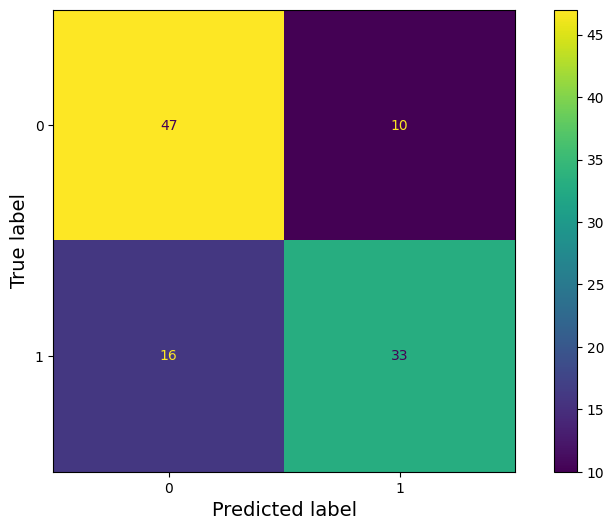

In [20]:
raw_model(LogisticRegression)

In [21]:
confusion_matrix_false_negative(33,16)

Taxa de falso negativo: 32.7%


Para o modelo logistic regression temos uma acurácia de 75.5% e uma taxa de falso negativo de 32.7%.

Método 2

In [22]:
cross_validate_raw_model(LogisticRegression)

Acurácia média 71.1%
Intervalo de acurácia: 60.2% - 82.0%


Utilizando o segundo método temos uma acurácia média de 71.1%.

##### SVC

Método 1

Taxa de acerto: 62.3%


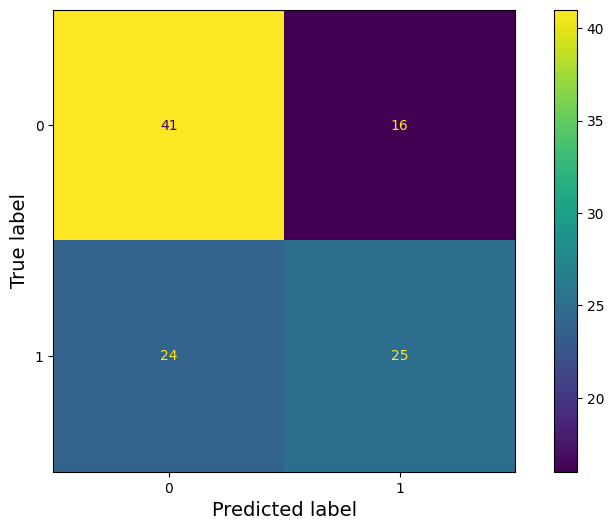

In [23]:
raw_model(SVC)

In [24]:
confusion_matrix_false_negative(25,24)

Taxa de falso negativo: 49.0%


Para o modelo SVC temos uma acurácia de 62.3% e uma taxa de falso negativo de 49.0%.

Método 2

In [25]:
cross_validate_raw_model(SVC)

Acurácia média 63.6%
Intervalo de acurácia: 54.3% - 72.8%


Utilizando o segundo método temos uma acurácia média de 63.6%.

##### LinearSVC

Método 1

Taxa de acerto: 53.8%


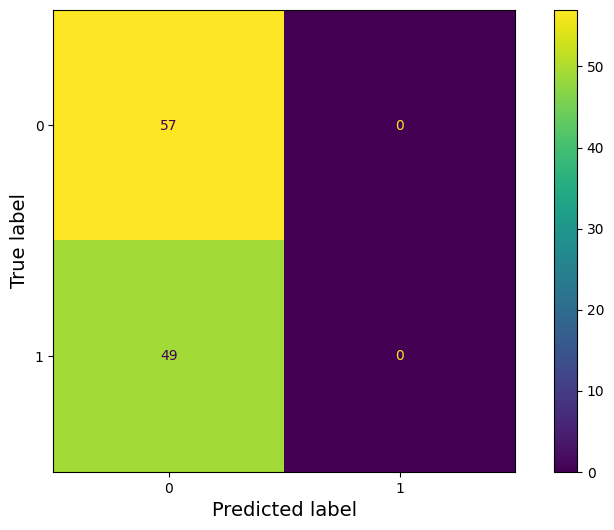

In [26]:
raw_model(LinearSVC)

In [27]:
confusion_matrix_false_negative(0,49)

Taxa de falso negativo: 100.0%


Para o modelo Linear SVC temos uma acurácia de 53.8% e uma taxa de falso negativo de 100%. Podemos notar que este modelo previu todos os pacientes como não precisando de UTI, ou seja, o modelo fez exatamente a mesma predição que o DummyClassfier.

Método 2

In [28]:
cross_validate_raw_model(LinearSVC)

Acurácia média 61.5%
Intervalo de acurácia: 43.4% - 79.6%


Utilizando o segundo método temos uma acurácia média de 61.5%.

##### DecisionTree

Método 1

Taxa de acerto: 70.8%


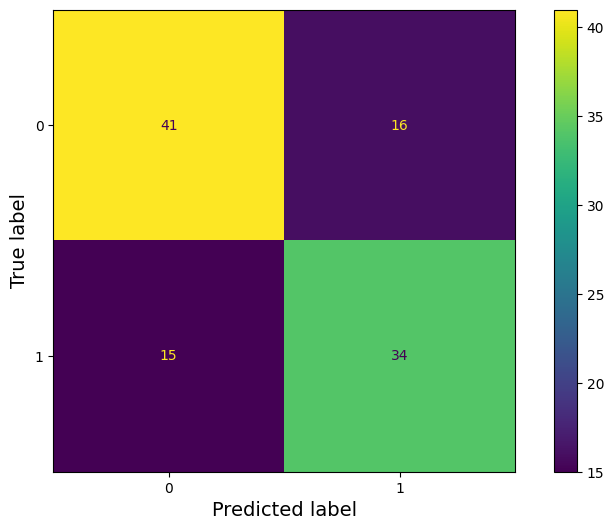

In [29]:
raw_model(DecisionTreeClassifier)

In [30]:
confusion_matrix_false_negative(34,15)

Taxa de falso negativo: 30.6%


Para o modelo decision tree temos uma acurácia de 70.8% e uma taxa de falso negativo de 30.6%.

Método 2

In [31]:
cross_validate_raw_model(DecisionTreeClassifier)

Acurácia média 64.2%
Intervalo de acurácia: 52.7% - 75.7%


Utilizando o segundo método temos uma acurácia média de 64.2%.

##### RandomForest

Método 1

Taxa de acerto: 78.3%


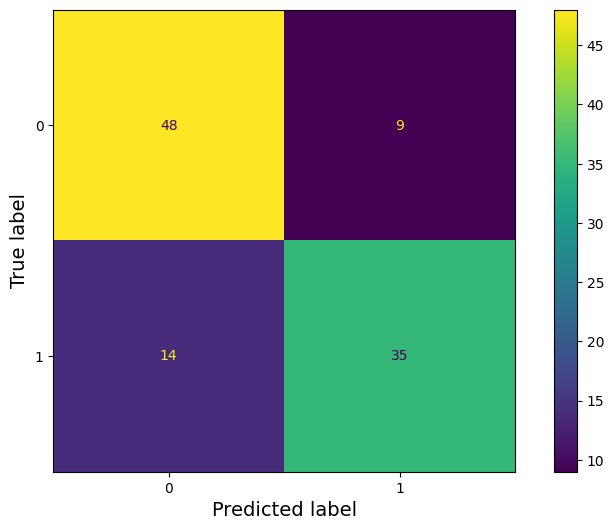

In [32]:
raw_model(RandomForestClassifier)

In [33]:
confusion_matrix_false_negative(35,14)

Taxa de falso negativo: 28.6%


Para o modelo random forest temos uma acurácia de 78.3% e uma taxa de falso negativo de 28.6%.

Método 2

In [34]:
cross_validate_raw_model(RandomForestClassifier)

Acurácia média 72.4%
Intervalo de acurácia: 62.1% - 82.7%


Utilizando o segundo método temos uma acurácia média de 72.4%.

##### GaussianProcess

Método 1

Taxa de acerto: 54.7%


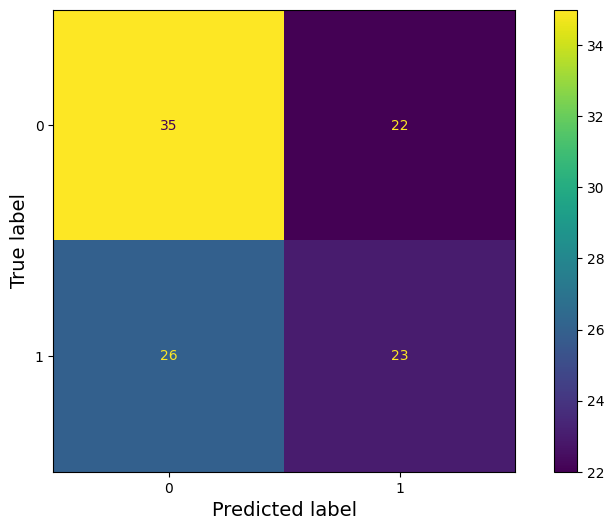

In [35]:
raw_model(GaussianProcessClassifier)

In [36]:
confusion_matrix_false_negative(23,26)

Taxa de falso negativo: 53.1%


Para o modelo Gaussian process temos uma acurácia de 54.7% e uma taxa de falso negativo de 53.1%.

Método 2

In [37]:
cross_validate_raw_model(GaussianProcessClassifier)

Acurácia média 55.7%
Intervalo de acurácia: 45.3% - 66.0%


Utilizando o segundo método temos uma acurácia média de 55.7%.

##### KNeighbors

Método 1

Taxa de acerto: 51.9%


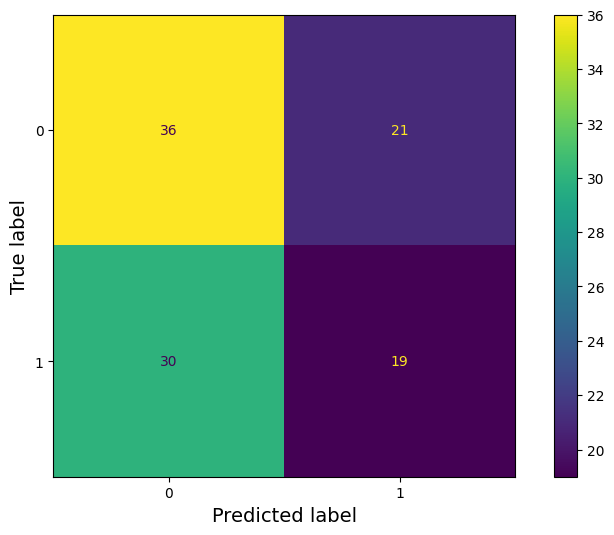

In [38]:
raw_model(KNeighborsClassifier)

In [39]:
confusion_matrix_false_negative(19,30)

Taxa de falso negativo: 61.2%


Para o modelo k-neighbors temos uma acurácia de 51.9% e uma taxa de falso negativo de 61.2%.

Método 2

In [40]:
cross_validate_raw_model(KNeighborsClassifier)

Acurácia média 58.8%
Intervalo de acurácia: 48.5% - 69.1%


Utilizando o segundo método temos uma acurácia média de 58.8%.

##### Modelo selecionado

O modelo RandomForest foi o que apresentou a melhor acurácia e a menor taxa de falso negativos no primeiro método e a melhor acurácia média no segundo método, portanto este é o modelo selecionado para as próximas análises.

#### Selecionando as features

Para selecionar as features vamos implementar dois processos. No primeiro, usando a matriz de correlação, vamos eliminar as features em que a correlação com alguma outra feature seja maior que 0.90, como implementado no curso. Após isso vamos utilizar a seleção de feature RFECV do sklearn para que o número ideal de features seja automaticamente selecionado. O primeiro processo de eliminar features altamente correlacionadas ainda é necessário pois o RFECV não as elimina.

##### Matriz de correlação

Aplicando o método desenvolvido no curso para eliminação de features com alta correlação (>0.90), onde features categóricas como PATIENT_VISIT_IDENTIFIER e GENDER não foram consideradas para eliminação, pois não faz sentido compararmos a correlação entre o ID e o sexo do paciente, por exemplo, obtemos:

In [41]:
corr_selected_filtered_raw_data().corr()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,ICU
PATIENT_VISIT_IDENTIFIER,1.000000,-0.017361,0.031159,0.071961,0.058683,0.022828,0.045907,-0.026074,-0.005678,0.021964,...,0.021779,-0.011847,-0.023686,-0.040615,-0.082139,-0.038959,-0.046410,-0.045353,-0.018859,-0.041382
AGE_ABOVE65,-0.017361,1.000000,0.874773,0.031830,0.280326,0.051308,0.165905,0.032608,0.314536,0.003930,...,0.104568,-0.086413,-0.109800,-0.012655,-0.026278,0.012440,-0.005558,0.028262,-0.030515,0.291010
AGE_PERCENTIL,0.031159,0.874773,1.000000,0.056211,0.294671,0.058015,0.134016,0.014480,0.334920,-0.035015,...,0.186620,-0.057003,-0.126255,-0.014140,-0.049698,-0.018826,-0.007992,-0.006030,-0.040314,0.351071
GENDER,0.071961,0.031830,0.056211,1.000000,0.036528,-0.001784,-0.064757,-0.069768,-0.019812,-0.020573,...,-0.111659,-0.137264,0.115275,-0.006168,-0.019919,0.079236,-0.016903,-0.012423,0.028744,-0.117938
DISEASE GROUPING 1,0.058683,0.280326,0.294671,0.036528,1.000000,0.196347,0.278271,0.017529,0.340370,0.202849,...,0.089330,-0.035513,0.025573,-0.054710,-0.053091,0.129220,-0.028964,-0.041099,-0.056287,0.071825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HEART_RATE_DIFF,-0.038959,0.012440,-0.018826,0.079236,0.129220,0.014222,-0.015035,-0.023554,0.011404,0.005530,...,-0.052509,0.016491,0.098880,0.397441,0.347893,1.000000,0.273000,0.296808,0.303616,-0.013554
RESPIRATORY_RATE_DIFF,-0.046410,-0.005558,-0.007992,-0.016903,-0.028964,-0.001618,-0.013900,0.016131,-0.045482,-0.042573,...,0.144543,0.146173,0.010051,0.338943,0.367821,0.273000,1.000000,0.286375,0.331205,0.093877
TEMPERATURE_DIFF,-0.045353,0.028262,-0.006030,-0.012423,-0.041099,-0.024705,0.000746,0.032550,-0.081749,0.004270,...,-0.031482,0.089025,-0.006765,0.381524,0.437913,0.296808,0.286375,1.000000,0.507736,-0.006336
OXYGEN_SATURATION_DIFF,-0.018859,-0.030515,-0.040314,0.028744,-0.056287,0.085122,0.005011,-0.026121,-0.098081,-0.033707,...,-0.023352,0.036438,-0.021277,0.537397,0.507730,0.303616,0.331205,0.507736,1.000000,0.020897


Dados antes da eliminação das features:

In [42]:
filtered_raw_data().shape

(352, 231)

Dados após a eliminaçào das features:

In [43]:
corr_selected_filtered_raw_data().shape

(352, 97)

Ou seja, das 231 features iniciais, depois da eliminação das features altamente correlacionadas temos 97 features.

##### RFECV

O método RFECV seleciona a melhor quantidade de features e as melhores features para que o modelo tenha a melhor acurácia. 

Para aplicar este método devemos primeiramente redefinir a variável $x$ considerando o resultado da análise da matriz de correlação:

In [44]:
x = corr_selected_filtered_raw_data()[corr_selected_filtered_raw_data().columns].drop(['ICU', 'WINDOW'], axis = 'columns')

In [45]:
x.shape

(352, 95)

Aplicando RFECV usando StratifiedKFold (o uso do RepeatedStratifiedKFold não é viável pois o algoritmo demora muito tempo para rodar), temos:

In [46]:
result = RFECV_selected_filtered_raw_data()

In [47]:
print(f'Número de features selecionadas: {result.n_features_}')

Número de features selecionadas: 7


In [48]:
print(f'Features selecionadas: {x.columns[result.support_]}')

Features selecionadas: Index(['AGE_PERCENTIL', 'CREATININ_MEDIAN', 'LINFOCITOS_MEDIAN', 'PCR_MEDIAN',
       'UREA_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEAN', 'RESPIRATORY_RATE_MEAN'],
      dtype='object')


Note que, entre as features categóricas, o RFECV nos retornou AGE_PERCENTIL como a mais importante para o nosso modelo. A feature GENDER não está na lista de features escolhidas, ou seja, o sexo do paciente não é uma característica importante para decidir se o paciente precisará de atendimento em UTI ou não, mas a faixa de idade é importante. Portanto, a análise visual que fizemos anteriormente diverge parcialmente do resultado do RFECV.

Outro ponto interessante é que o modelo selecionou a feature RESPIRATORY_RATE_MEAN como uma feature importante, e sabemos que problemas respiratórios são um dos sintomas da COVID-19 [[5]](https://www.cnnbrasil.com.br/saude/estudo-alta-carga-de-coronavirus-nos-pulmoes-tem-relacao-com-mortes-por-covid/).

Plotando o processo de seleção de features temos:

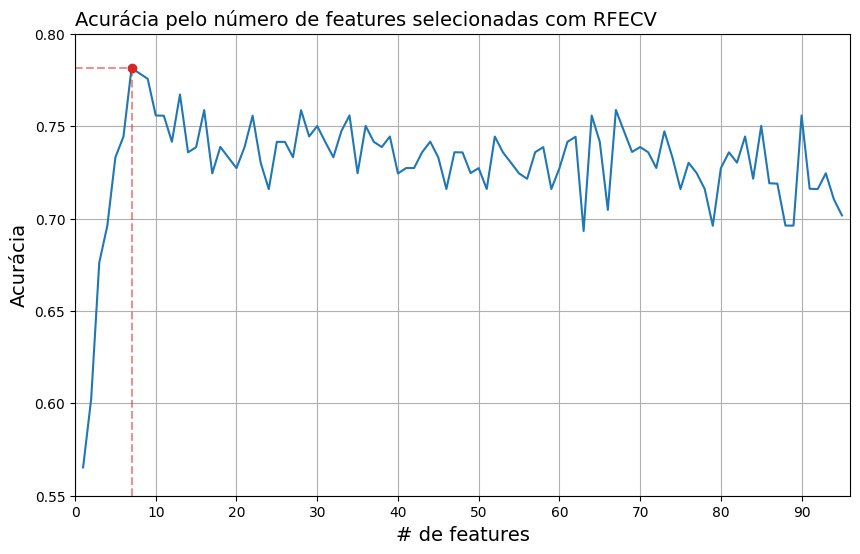

In [50]:
plot_features(result)

Portanto, temos a acurácia máxima com 7 features selecionadas e, a partir deste valor, a acurácia do modelo diminui.

##### Calculando a acurácia do modelo

Utilizando apenas as features selecionadas pelo RFECV, nesta seção calculamos a acurácia do modelo e a taxa de falso negativo e as comparamos com o resultado da seção 'Selecionando o modelo'.

Para isso temos que redefinir x, x_train e x_test:

In [51]:
selected_x_columns = corr_selected_filtered_raw_data()[corr_selected_filtered_raw_data().columns].drop(['ICU', 'WINDOW'], axis = 'columns').columns[result.support_]
x = filtered_raw_data()[filtered_raw_data().columns].drop(columns=[column for column in filtered_raw_data().columns if column not in selected_x_columns])
x

,,AGE_PERCENTIL,CREATININ_MEDIAN,LINFOCITOS_MEDIAN,PCR_MEDIAN,UREA_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,RESPIRATORY_RATE_MEAN
0,0,60,-0.868365,-0.914938,-0.875236,-0.836145,0.086420,-0.593220
1,10,10,-0.912243,-0.908714,-0.939887,-0.836145,-0.489712,-0.645951
2,15,40,-0.968861,-0.836100,-0.503592,-0.937349,0.012346,-0.457627
3,20,10,-0.913659,-0.641079,-0.990926,-0.903614,0.333333,-0.593220
4,25,10,-0.891012,-0.340249,-0.997732,-0.884337,-0.037037,-0.525424
...,...,...,...,...,...,...,...,...
348,1900,40,-0.937721,-0.879668,-0.565974,-0.860241,-0.160494,-0.457627
349,1905,100,-0.886766,-0.921162,-0.993195,-0.855422,-0.407407,-0.457627
350,1910,50,-0.905166,-0.838174,-0.034405,-0.787952,0.012346,-0.457627
351,1915,40,-0.922151,-0.819502,-0.804159,-0.937349,0.086420,-0.661017


In [52]:
np.random.seed(5678)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, stratify=y)

Método 1

Taxa de acerto: 79.2%


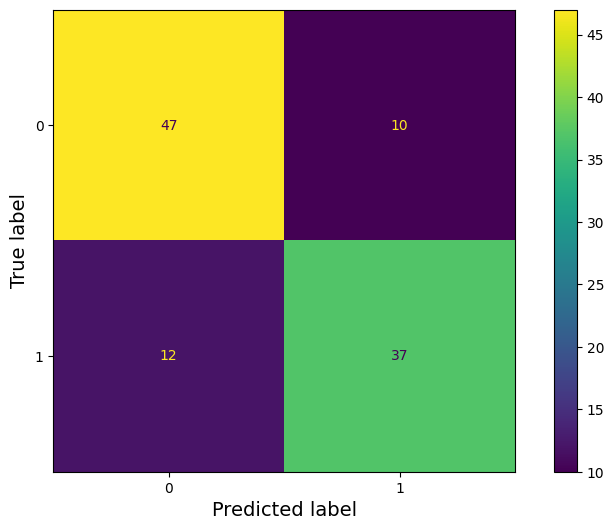

In [53]:
raw_model(RandomForestClassifier)

In [54]:
confusion_matrix_false_negative(37,12)

Taxa de falso negativo: 24.5%


Depois da seleção das features a acurácia do modelo aumentou de 78.3% para 79.2% e a taxa de falso positivo caiu de 28.6% para 24.5%.

Método 2

In [55]:
np.random.seed(5678)

# embaralhando os dados:
dados_xy = filtered_raw_data().sample(frac=1).reset_index(drop=True)

y = dados_xy['ICU']
x = dados_xy[dados_xy.columns].drop(columns=[column for column in filtered_raw_data().columns if column not in selected_x_columns])

model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
resultados = cross_validate(model, x, y, cv=cv, scoring='accuracy')['test_score']

acuracia_media = resultados.mean()
acuracia_std = resultados.std()
print(f'Acurácia média {"%.1f" %(acuracia_media*100)}%')
print(f'Intervalo de acurácia: {"%.1f" %((acuracia_media - 2*acuracia_std)*100)}% - {"%.1f" %((acuracia_media + 2*acuracia_std)*100)}%')

Acurácia média 74.9%
Intervalo de acurácia: 64.8% - 85.1%


Depois da seleção das features a acurácia média do modelo aumentou de 72.4% para 74.9%

#### Selecionando os parâmetros

Para selecionar os melhores parâmetros para o modelo utilizaremos o RandomizedSearchCV. Os parâmetros n_stimators, criterion, e max_depth serão analisados pelo RandomizedSearchCV e o best_estimator_ retornará a combinação de parâmetros com a maior acurácia. Posteriormente, a acurácia e a taxa de falso negativo serão comparadas com o resultado da seção anterior.

In [56]:
np.random.seed(5678)

parameters = {'n_estimators': randint(100,300), 'criterion': ['gini', 'entropy'],
                    'max_depth': [None,1,2,3,4,5]}

cv = StratifiedKFold(n_splits=5, shuffle=True)
parameter_search = RandomizedSearchCV(RandomForestClassifier(), parameters, 
                                            cv = cv, n_iter=64, scoring='accuracy')
parameter_search.fit(x, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
                   estimator=RandomForestClassifier(), n_iter=64,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 1, 2, 3, 4, 5],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fadb87e7d00>},
                   scoring='accuracy')

In [57]:
parameter_search.best_estimator_

RandomForestClassifier(max_depth=5, n_estimators=254)

Método 1

Taxa de acerto: 74.5%


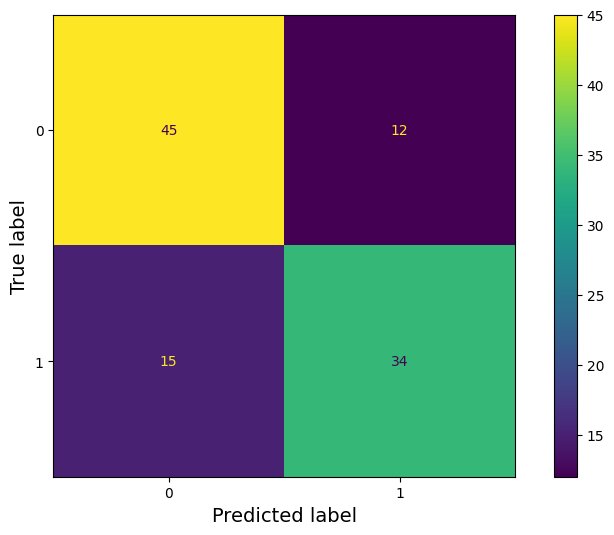

In [58]:
np.random.seed(5678)
model = RandomForestClassifier(max_depth=5, n_estimators=254)
model.fit(x_train, y_train)
y_prediction=model.predict(x_test)
print(f'Taxa de acerto: {"%.1f" %(accuracy_score(y_test, y_prediction)*100)}%')
plot_confusion_matrix(model, x_test, y_test)

In [59]:
confusion_matrix_false_negative(34, 15)

Taxa de falso negativo: 30.6%


Depois da seleção dos parâmetros e das features a acurácia do modelo diminuiu para 74.5% e a taxa de falso positivo aumentou para 30.6%

Método 2

In [60]:
np.random.seed(5678)

# embaralhando os dados:
dados_xy = filtered_raw_data().sample(frac=1).reset_index(drop=True)

y = dados_xy['ICU']
x = dados_xy[dados_xy.columns].drop(columns=[column for column in filtered_raw_data().columns if column not in selected_x_columns])

model = RandomForestClassifier(max_depth=5, n_estimators=254)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
resultados = cross_validate(model, x, y, cv=cv, scoring='accuracy')['test_score']

acuracia_media = resultados.mean()
acuracia_std = resultados.std()
print(f'Acurácia média {"%.1f" %(acuracia_media*100)}%')
print(f'Intervalo de acurácia: {"%.1f" %((acuracia_media - 2*acuracia_std)*100)}% - {"%.1f" %((acuracia_media + 2*acuracia_std)*100)}%')

Acurácia média 76.1%
Intervalo de acurácia: 65.8% - 86.5%


Depois da seleção dos parâmetros e das features a acurácia média do modelo aumentou para 76.1%

# Conclusão

Neste projeto analisamos a base de dados do hospital Sírio-Libanês com o objetivo de prever se um paciente internado por COVID-19 precisará ou não de atendimento em UTI. Na primeira análise, sem o uso de modelos de machine learning, observamos que a faixa de idade do paciente podería ser um fator importante, e que o sexo masculino é mais internado do que o sexo feminino. Entretanto, resaltamos que a diferença no número de internação entre homens e mulheres pode ser por motivo socioeconomicos, por exemplo. Na segunda análise, usando modelos de machine learning, o algoritmo random forest foi o que obteve maior taxa de acurácia média por dois métodos de análise diferentes, cerca de 76% com intervalo de 65.8% a 86.5%, valor maior que o baseline de 53.8%, além disso, o modelo apresentou uma taxa de falso negativo de cerca de 30%, um valor menor quando comparado com o Dummy classifier, que apresentou uma taxa de falso negativo de 100%.

# Referências

Base de dados: https://www.kaggle.com/S%C3%ADrio-Libanes/covid19

[1] https://g1.globo.com/bemestar/coronavirus/noticia/2021/03/20/mortes-na-fila-por-um-leito-de-uti-falta-de-insumos-e-funerarias-sem-ferias-os-sinais-do-colapso-na-saude-brasileira.ghtml

[2] https://scikit-learn.org/stable/

[3] https://www.kaggle.com/S%C3%ADrio-Libanes/covid19/discussion/164019

[4] https://www.bbc.com/portuguese/geral-52901162

[5] https://www.cnnbrasil.com.br/saude/estudo-alta-carga-de-coronavirus-nos-pulmoes-tem-relacao-com-mortes-por-covid/